In [1]:
!pip install ta


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install yfinance


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install backtesting


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install backtrader


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import ta
import yfinance as yf
import ssl

In [6]:

# Ignore SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

data = pd.read_html("https://en.wikipedia.org/wiki/NIFTY_50#Constituents")[2]
tickers = data.Symbol.to_list()

tickers = [i + ".NS" for i in tickers]

tickers

['ADANIENT.NS',
 'ADANIPORTS.NS',
 'APOLLOHOSP.NS',
 'ASIANPAINT.NS',
 'AXISBANK.NS',
 'BAJAJ-AUTO.NS',
 'BAJFINANCE.NS',
 'BAJAJFINSV.NS',
 'BPCL.NS',
 'BHARTIARTL.NS',
 'BRITANNIA.NS',
 'CIPLA.NS',
 'COALINDIA.NS',
 'DIVISLAB.NS',
 'DRREDDY.NS',
 'EICHERMOT.NS',
 'GRASIM.NS',
 'HCLTECH.NS',
 'HDFCBANK.NS',
 'HDFCLIFE.NS',
 'HEROMOTOCO.NS',
 'HINDALCO.NS',
 'HINDUNILVR.NS',
 'ICICIBANK.NS',
 'INDUSINDBK.NS',
 'INFY.NS',
 'ITC.NS',
 'JSWSTEEL.NS',
 'KOTAKBANK.NS',
 'LT.NS',
 'LTIM.NS',
 'M&M.NS',
 'MARUTI.NS',
 'NESTLEIND.NS',
 'NTPC.NS',
 'ONGC.NS',
 'POWERGRID.NS',
 'RELIANCE.NS',
 'SBILIFE.NS',
 'SHRIRAMFIN.NS',
 'SBIN.NS',
 'SUNPHARMA.NS',
 'TCS.NS',
 'TATACONSUM.NS',
 'TATAMOTORS.NS',
 'TATASTEEL.NS',
 'TECHM.NS',
 'TITAN.NS',
 'ULTRACEMCO.NS',
 'WIPRO.NS']

In [7]:
def RSI(asset):
    df = yf.download(asset, start = '2021-01-01', end = '2024-01-01')
    df['MA200'] = df["Adj Close"].rolling(window = 200).mean()
    df['Upmove'] = (df['Close'] - df['Open']).apply(lambda x: x if x > 0 else 0)
    df['Downmove'] = (df['Close'] - df['Open']).apply(lambda x: abs(x) if x < 0 else 0)
    df['avg_up'] = df['Upmove'].ewm(span=14, min_periods=14).mean()
    df['avg_down'] = df['Downmove'].ewm(span=14, min_periods=14).mean()
    df.dropna(inplace=True)
    df['RS'] = df['avg_up'] / df['avg_down']
    df['RSI'] = 100 - (100 / (1 + df['RS']))
    df.loc[(df['Adj Close']>df['MA200']) & (df['RSI'] < 30), 'BUY'] = "YES"
    df.loc[(df['Adj Close']<df['MA200'] )| (df['RSI'] > 30), 'BUY'] = "NO"
    return df


In [8]:
def getSignalRSI(df):
    Buy_dates = []
    Sell_dates = []
    for i in range(len(df) - 21):
        if "YES" in df['BUY'].iloc[i]:
            Buy_dates.append(df.iloc[i+1].name)
            for j in range(1,21):
                if df['RSI'].iloc[i+j] > 70:
                    Sell_dates.append(df.iloc[i+j+1].name)
                    break
                elif j == 20:
                    Sell_dates.append(df.iloc[i+j+1].name)

    return Buy_dates,Sell_dates
        

In [9]:
d = RSI(tickers[3])
Buy,Sell = getSignalRSI(d)

[*********************100%%**********************]  1 of 1 completed
/var/folders/28/x8q2f_yx2g7881jgwz63bk5r0000gn/T/ipykernel_33971/3020205122.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'YES' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Adj Close']>df['MA200']) & (df['RSI'] < 30), 'BUY'] = "YES"


In [10]:
import matplotlib.pyplot as plt

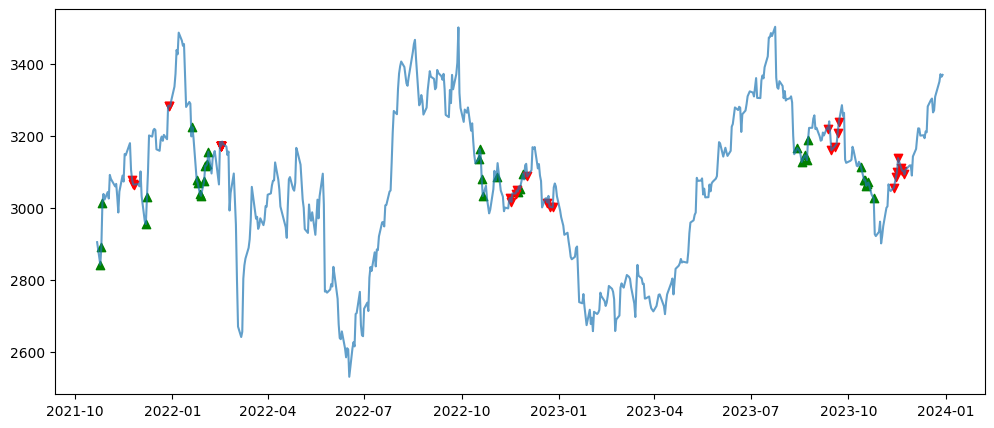

In [11]:
plt.figure(figsize=(12,5))
plt.scatter(d.loc[Buy].index,d.loc[Buy]['Adj Close'], marker = '^', color = 'g')
plt.scatter(d.loc[Sell].index,d.loc[Sell]['Adj Close'], marker = 'v', color = 'r')
plt.plot(d['Adj Close'], alpha = 0.7)

In [12]:
profits = (d.loc[Sell].Open.values - d.loc[Buy].Open.values)/d.loc[Buy].Open.values

Net_prof = (1+profits).cumprod()
Net_prof

array([1.08001697, 1.1682711 , 1.19596222, 1.32665254, 1.47555585,
       1.47465667, 1.48007157, 1.56601121, 1.63578122, 1.71417329,
       1.7906014 , 1.83881421, 1.88196159, 1.92129537, 1.97674053,
       1.91083887, 1.83602044, 1.78262773, 1.76218996, 1.80086728,
       1.78581663, 1.76497928, 1.73644455, 1.7771388 , 1.81077961,
       1.83375896, 1.84757259, 1.87654783, 1.8455699 , 1.82294333,
       1.81248334, 1.83579502, 1.88407253, 1.92330748, 1.95725485])

MACD Indicator

In [13]:
def MACD(asset):
    df = yf.download(asset, start = '2023-11-01', end = '2024-01-01', interval = '1h')
    df['EMA12'] = df['Adj Close'].ewm(span = 12).mean()
    df['EMA26'] = df['Adj Close'].ewm(span = 26).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span = 9).mean()
    return df

In [14]:
MACD_Frame = MACD(tickers[5])
MACD_Frame

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,EMA12,EMA26,MACD,Signal
Datetime,,,,,,,,,,
2023-11-01 09:15:00+05:30,5413.649902,5438.350098,5348.600098,5374.899902,5374.899902,0,5374.899902,5374.899902,0.000000,0.000000
2023-11-01 10:15:00+05:30,5375.000000,5385.000000,5361.350098,5370.000000,5370.000000,48197,5372.245789,5372.355722,-0.109934,-0.061074
2023-11-01 11:15:00+05:30,5376.299805,5399.950195,5370.000000,5382.899902,5382.899902,128322,5376.404092,5376.144144,0.259948,0.070492
2023-11-01 12:15:00+05:30,5382.850098,5385.000000,5362.100098,5367.899902,5367.899902,63117,5373.719651,5373.839414,-0.119763,0.006043
2023-11-01 13:15:00+05:30,5367.850098,5375.000000,5363.850098,5372.000000,5372.000000,44133,5373.252428,5373.412846,-0.160418,-0.043476
...,...,...,...,...,...,...,...,...,...,...
2023-12-29 11:15:00+05:30,6710.350098,6734.000000,6701.000000,6720.100098,6720.100098,28740,6677.572693,6604.310241,73.262452,77.215016
2023-12-29 12:15:00+05:30,6722.750000,6760.000000,6718.149902,6750.350098,6750.350098,46708,6688.769216,6615.128008,73.641209,76.500255
2023-12-29 13:15:00+05:30,6752.500000,6757.899902,6732.000000,6740.549805,6740.549805,29652,6696.735461,6624.418511,72.316949,75.663594


In [15]:
Buy,Sell = [],[]
for i in range (2,len(MACD_Frame)):
    if MACD_Frame.MACD.iloc[i] > MACD_Frame.Signal.iloc[i] and MACD_Frame.MACD.iloc[i - 1] < MACD_Frame.Signal.iloc[i - 1]:
        Buy.append(i+1)
    elif MACD_Frame.MACD.iloc[i] < MACD_Frame.Signal.iloc[i] and MACD_Frame.MACD.iloc[i - 1] > MACD_Frame.Signal.iloc[i - 1]:
        Sell.append(i+1)
    

In [16]:
Buy = [i for i in Buy if i < len(MACD_Frame)]
Sell = [i for i in Sell if i < len(MACD_Frame)]

Buy_Price = MACD_Frame.Open.iloc[Buy]
Sell_Price = MACD_Frame.Open.iloc[Sell]


In [17]:
if Buy_Price.index[0] > Sell_Price.index[0]:
    Sell_Price = Sell_Price.drop(Sell_Price.index[-1])
elif Buy_Price.index[-1] > Sell_Price.index[-1]:
    Buy_Price  = Buy_Price.drop(Buy_Price.index[-1])

In [18]:
Profits = []

for i in range(len(Buy_Price)):
    Profits.append((Sell_Price.iloc[i] - Buy_Price.iloc[i])/Buy_Price.iloc[i])

In [19]:
Profits = np.array(Profits)

In [20]:
Net_Profits = (1 + Profits).cumprod()
Net_Profits

array([0.99721337, 1.01277692, 1.00818181, 1.04816636, 1.08154284,
       1.07661752, 1.07164304, 1.06693036, 1.0589654 , 1.09253457,
       1.08880911, 1.1433392 ])

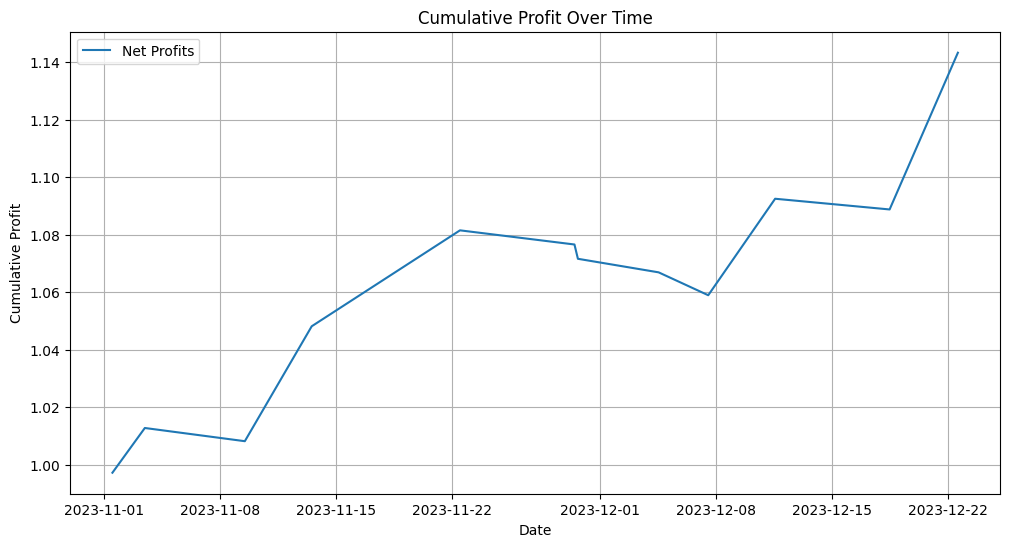

In [21]:
dates = MACD_Frame.index[Buy[:len(Net_Profits)]] 

# Plot cumulative profit over time
plt.figure(figsize=(12, 6))
plt.plot(dates, Net_Profits, label='Net Profits')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit Over Time')
plt.legend()
plt.grid(True)
plt.show()

SENTIMENT ANALYSIS

In [22]:
pip install feedparser textblob 



[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


1. Google news

In [23]:
import feedparser
from textblob import TextBlob
from datetime import datetime

# Define the RSS feed URL for HDFC Bank news
rss_url = 'https://news.google.com/rss/search?q=HDFC+Bank'

def fetch_rss_feed(url):
    feed = feedparser.parse(url)
    news_data = []
    
    for entry in feed.entries:
        title = entry.title
        description = entry.summary
        date = datetime.strptime(entry.published, '%a, %d %b %Y %H:%M:%S %Z')
        
        news_data.append({'title': title, 'description': description, 'date': date})
    
    return news_data

# Fetch news articles
articles = fetch_rss_feed(rss_url)

# Define date range
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 2, 15)

# Filter articles by date
filtered_articles = [article for article in articles if start_date <= article['date'] <= end_date]

# Check if there are any articles in the specified date range
if filtered_articles:
    print(f"Found {len(filtered_articles)} articles within the date range.")
    # Analyze sentiment
    sentiment_scores = []
    dates = []

    for article in filtered_articles:
        text = article['title'] + " " + article['description']
        blob = TextBlob(text)
        sentiment_scores.append(blob.sentiment.polarity)
        dates.append(article['date'])

    # Convert to DataFrame for easier plotting
    df = pd.DataFrame({
        'Date': dates,
        'Sentiment Score': sentiment_scores
    })

    # Sort by date
    df.sort_values(by='Date', inplace=True)

    # Plot sentiment scores
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Sentiment Score'], marker='o', linestyle='-', color='b', label='Sentiment Score')
    plt.axvline(pd.to_datetime("2024-01-16"), color='r', linestyle='--', label='Significant Drop Date')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.title('Sentiment Analysis of HDFC Bank from January 1, 2024, to February 15, 2024')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("No articles found within the specified date range.")


No articles found within the specified date range.


2. Using newsapi

In [24]:
import requests
from datetime import timedelta

# NewsAPI endpoint and key (replace with your API key)
api_key = 'API_KEY'
endpoint = 'https://newsapi.org/v2/everything'

def fetch_news_articles(query, from_date, to_date):
    url = f'{endpoint}?q={query}&from={from_date}&to={to_date}&apiKey={api_key}'
    response = requests.get(url)
    data = response.json()
    return data

def check_date_range(query, start_date, end_date):
    response = fetch_news_articles(query, start_date, end_date)
    articles = response.get('articles', [])
    if articles:
        # Determine earliest and latest dates in the response
        dates = [article['publishedAt'][:10] for article in articles]
        earliest_date = min(dates)
        latest_date = max(dates)
        return earliest_date, latest_date
    return None, None

# Define a date range for checking
start_date = '2024-01-01'
end_date = '2024-02-15'

# Check available date range
earliest_date, latest_date = check_date_range('HDFC Bank', start_date, end_date)

if earliest_date and latest_date:
    print(f"Articles available from {earliest_date} to {latest_date}.")
else:
    print("No articles found in the specified date range.")


No articles found in the specified date range.


3. Using beautifulsoup4

In [25]:
pip install beautifulsoup4


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
from bs4 import BeautifulSoup

# Function to fetch and parse news articles from Economic Times
def fetch_news_from_economic_times(query, start_date, end_date):
    url = f'https://economictimes.indiatimes.com/search/news/{query}?from={start_date}&to={end_date}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    articles = []

    # Find article containers (update selectors based on actual HTML structure)
    article_elements = soup.find_all('div', class_='eachStory')

    for article in article_elements:
        title_element = article.find('a', class_='title')
        date_element = article.find('span', class_='date')

        if title_element and date_element:
            title = title_element.text.strip()
            date_text = date_element.text.strip()

            # Parse date and check if it's within the range
            try:
                article_date = datetime.strptime(date_text, '%d %b %Y')
                if start_date <= article_date <= end_date:
                    articles.append((title, article_date))
            except ValueError:
                continue

    return articles

# Define the query, URL, and date range
query = 'HDFC Bank'
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 2, 15)

# Fetch articles
articles = fetch_news_from_economic_times(query, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

if articles:
    print(f"Found {len(articles)} articles within the date range.")
    for title, date in articles:
        print(f"Date: {date.strftime('%Y-%m-%d')}, Title: {title}")
else:
    print("No articles found within the specified date range.")


No articles found within the specified date range.


4. Using polygon api

In [27]:
# Function to fetch news data from Polygon.io
def fetch_news_from_polygon(api_key, ticker, start_date, end_date):
    url = "https://api.polygon.io/v2/reference/news"
    params = {
        'apiKey': api_key,
        'symbols': ticker,
        'startDate': start_date,
        'endDate': end_date
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    if data and 'results' in data:
        articles = data['results']
        return articles
    else:
        return []

# Define the API key and query parameters
api_key = "rD1IlfGgjiQpem6Eews_sg1YQkQpoGAw"  
ticker = 'HDFCBANK'  
start_date = '2024-01-01'
end_date = '2024-02-15'

# Fetch news articles
news_articles = fetch_news_from_polygon(api_key, ticker, start_date, end_date)

if news_articles:
    print(f"Found {len(news_articles)} articles within the date range.")
    for article in news_articles:
        print(f"Date: {article['published_utc']}, Title: {article['title']}")
else:
    print("No articles found within the specified date range.")


Found 10 articles within the date range.
Date: 2024-07-24T04:54:20Z, Title: What will a Trump presidency look like for China's economy? ANZ weighs in - Investing.com
Date: 2024-07-24T04:47:19Z, Title: Morning Bid: Lacklustre earnings keep investors jittery By Reuters - Investing.com Canada
Date: 2024-07-24T04:38:26Z, Title: America’s Construction Sites Are Desperate For Robots — This House-Printing Startup Is Making Them - Benzinga
Date: 2024-07-24T04:33:32Z, Title: Mark Zuckerberg Family Office-Backed Google Translate Rival DeepL Expands Language Offerings With Traditional Chinese Targeting Baidu, Tencent - Benzinga
Date: 2024-07-24T04:22:20Z, Title: Australian Shares Slip After US Market Decline By Kalkine Media - Investing.com Australia
Date: 2024-07-24T04:05:23Z, Title: Sundar Pichai Opens Up On Why Google Is Holding On To Cookies: 'We Now Believe User Choice Is The Best Path Forward' - Benzinga
Date: 2024-07-24T04:01:11Z, Title: Peter Schiff Polls HODLers, Asks If They'll Sell If 

No data available for 15-01-2024 to 20-01-2024.
So lets focus on what we have

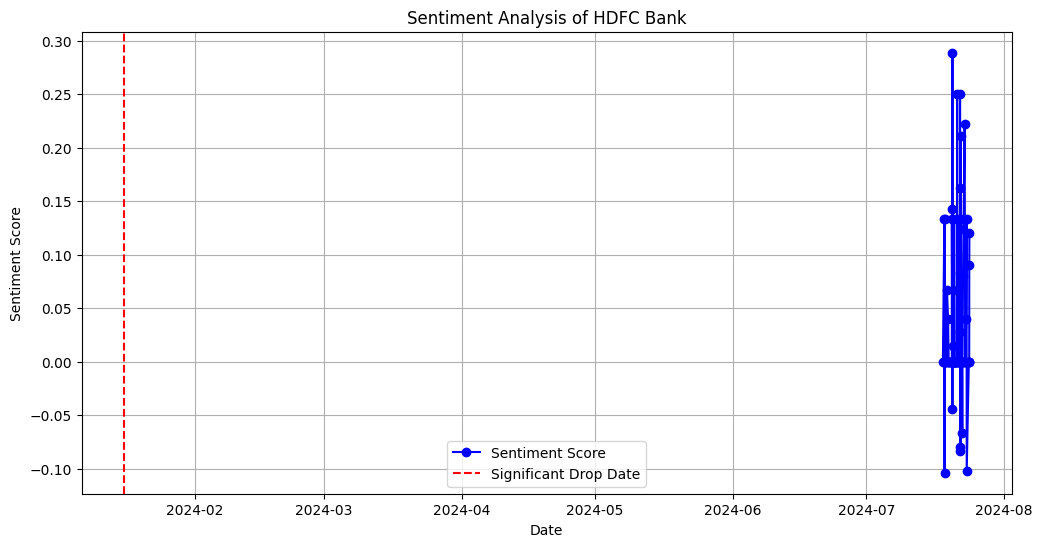

In [28]:
# RSS Feed URL for HDFC Bank news
rss_url = 'https://news.google.com/rss/search?q=HDFC+Bank'

def fetch_rss_feed(url):
    feed = feedparser.parse(url)
    news_data = []
    
    for entry in feed.entries:
        title = entry.title
        description = entry.summary
        date = entry.published
        
        news_data.append({'title': title, 'description': description, 'date': date})
    
    return news_data

# Fetch news articles
articles = fetch_rss_feed(rss_url)

# Analyze sentiment
sentiment_scores = []
dates = []

for article in articles:
    text = article['title'] + " " + article['description']
    blob = TextBlob(text)
    sentiment_scores.append(blob.sentiment.polarity)
    dates.append(article['date'])

# Convert to DataFrame for easier plotting
df = pd.DataFrame({
    'Date': pd.to_datetime(dates),
    'Sentiment Score': sentiment_scores
})

# Sort by date
df.sort_values(by='Date', inplace=True)

# Plot sentiment scores
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Sentiment Score'], marker='o', linestyle='-', color='b', label='Sentiment Score')
plt.axvline(pd.to_datetime("2024-01-16"), color='r', linestyle='--', label='Significant Drop Date')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis of HDFC Bank')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
from datetime import datetime

# Parse the RSS feed
feed = feedparser.parse(rss_url)

# Extract publication dates
dates = []
for entry in feed.entries:
    if 'published' in entry:
        date_str = entry.published
        date = datetime.strptime(date_str, '%a, %d %b %Y %H:%M:%S %Z')
        dates.append(date)

# Find the earliest and latest dates
if dates:
    earliest_date = min(dates)
    latest_date = max(dates)
    print(f"News data is available from {earliest_date} to {latest_date}")
else:
    print("No news data available")

News data is available from 2024-07-18 05:50:36 to 2024-07-24 04:52:31


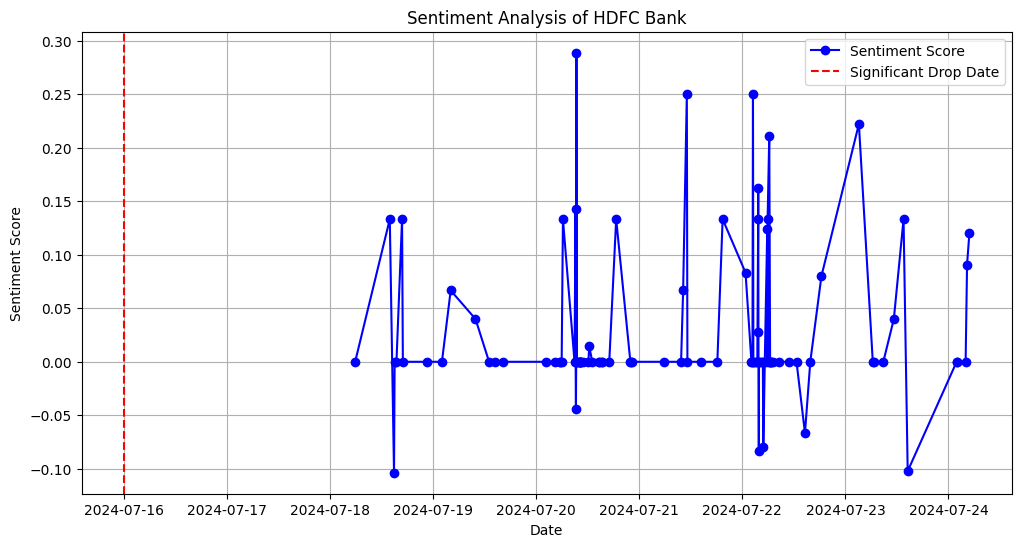

In [30]:
# Plot the available sentiment scores
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Sentiment Score'], marker='o', linestyle='-', color='b', label='Sentiment Score')
plt.axvline(pd.to_datetime("2024-07-16"), color='r', linestyle='--', label='Significant Drop Date')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis of HDFC Bank')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
def RSI(asset):
    df = yf.download(asset, start = '2024-05-01', end = '2024-07-24')
    df['MA200'] = df["Adj Close"].rolling(window = 200).mean()
    df['Upmove'] = (df['Close'] - df['Open']).apply(lambda x: x if x > 0 else 0)
    df['Downmove'] = (df['Close'] - df['Open']).apply(lambda x: abs(x) if x < 0 else 0)
    df['avg_up'] = df['Upmove'].ewm(span=14, min_periods=14).mean()
    df['avg_down'] = df['Downmove'].ewm(span=14, min_periods=14).mean()
    df.dropna(inplace=True)
    df['RS'] = df['avg_up'] / df['avg_down']
    df['RSI'] = 100 - (100 / (1 + df['RS']))
    df.loc[(df['Adj Close']>df['MA200']) & (df['RSI'] < 30), 'BUY'] = "YES"
    df.loc[(df['Adj Close']<df['MA200'] )| (df['RSI'] > 30), 'BUY'] = "NO"
    return df

In [32]:
def RSI(asset, analysis_start_date, analysis_end_date):
    # Define a broader start date to ensure enough data for the 200-day moving average and RSI calculation
    broader_start_date = '2023-12-01'  # This provides more than 200 days of data prior to the analysis period
    
    df = yf.download(asset, start=broader_start_date, end=analysis_end_date)
    
    if df.empty:
        raise ValueError(f"No data found for {asset} in the specified date range.")
    
    df['MA200'] = df["Adj Close"].rolling(window=200).mean()
    df['Upmove'] = (df['Close'] - df['Open']).apply(lambda x: x if x > 0 else 0)
    df['Downmove'] = (df['Close'] - df['Open']).apply(lambda x: abs(x) if x < 0 else 0)
    df['avg_up'] = df['Upmove'].ewm(span=14, min_periods=14).mean()
    df['avg_down'] = df['Downmove'].ewm(span=14, min_periods=14).mean()
    df.dropna(inplace=True)
    df['RS'] = df['avg_up'] / df['avg_down']
    df['RSI'] = 100 - (100 / (1 + df['RS']))
    
    # Filter the DataFrame to only include the desired date range
    df = df[analysis_start_date:analysis_end_date]
    
    # Check if there are still rows after filtering
    if df.empty:
        raise ValueError(f"Not enough data to calculate RSI for {asset} in the specified date range.")
    
    df.loc[(df['Adj Close'] > df['MA200']) & (df['RSI'] < 30), 'BUY'] = "YES"
    df.loc[(df['Adj Close'] < df['MA200']) | (df['RSI'] > 30), 'BUY'] = "NO"
    return df

# Apply the RSI function for HDFC Bank with the desired analysis period
try:
    hdfc_rsi = RSI('HDFCBANK.NS', analysis_start_date='2024-07-16', analysis_end_date='2024-07-23')
    print(hdfc_rsi)
except ValueError as e:
    print(e)

[*********************100%%**********************]  1 of 1 completed

Not enough data to calculate RSI for HDFCBANK.NS in the specified date range.


In [33]:
def RSI(asset):
    # Download data from 01-06-2024 to 24-07-2024 to ensure enough data for the 21-day moving average
    df = yf.download(asset, start='2024-06-01', end='2024-07-24')
    
    if df.empty:
        print("No data downloaded for the specified date range.")
        return df
    
    # 21-day moving average
    df['MA21'] = df["Adj Close"].rolling(window=21).mean()
    
    # 200-day moving average (if still needed)
    df['MA200'] = df["Adj Close"].rolling(window=200).mean()
    
    df['Upmove'] = (df['Close'] - df['Open']).apply(lambda x: x if x > 0 else 0)
    df['Downmove'] = (df['Close'] - df['Open']).apply(lambda x: abs(x) if x < 0 else 0)
    df['avg_up'] = df['Upmove'].ewm(span=14, min_periods=14).mean()
    df['avg_down'] = df['Downmove'].ewm(span=14, min_periods=14).mean()
    
    # Ensure we only drop rows with NaN values for necessary columns
    df.dropna(subset=['avg_up', 'avg_down', 'MA21'], inplace=True)
    
    if df.empty:
        print("DataFrame is empty after dropping NaN values.")
        return df
    
    df['RS'] = df['avg_up'] / df['avg_down']
    df['RSI'] = 100 - (100 / (1 + df['RS']))
    
    # Define BUY signal based on 21-day moving average
    df.loc[(df['Adj Close'] > df['MA21']) & (df['RSI'] < 30), 'BUY'] = "YES"
    df.loc[(df['Adj Close'] <= df['MA21']) | (df['RSI'] >= 30), 'BUY'] = "NO"
    
    # Filter data to only include the specified study period
    df = df.loc['2024-07-16':'2024-07-23']
    
    if df.empty:
        print("DataFrame is empty after filtering for the specified study period.")
    
    return df

# Dummy function for getSignalRSI to avoid error
def getSignalRSI(df):
    buy_signals = df[df['BUY'] == 'YES']
    sell_signals = df[df['BUY'] == 'NO']
    return buy_signals, sell_signals

# List of tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

# Call the RSI function for a specific asset
d = RSI(tickers[3])

if not d.empty:
    Buy, Sell = getSignalRSI(d)
    print("Buy signals:")
    print(Buy)
    print("Sell signals:")
    print(Sell)
else:
    print("No data available for buy/sell signals.")


[*********************100%%**********************]  1 of 1 completed

Buy signals:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-16  195.589996  196.619995  192.240005  193.020004  193.020004   

              Volume        MA21  MA200  Upmove  Downmove    avg_up  avg_down  \
Date                                                                            
2024-07-16  33994700  192.896191    NaN     0.0  2.569992  0.605042  1.428999   

                  RS        RSI  BUY  
Date                                  
2024-07-16  0.423403  29.745824  YES  
Sell signals:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-17  191.350006  191.580002  185.990005  187.929993  187.929993   
2024-07-18  189.589996  189.679993  181.449997  183.750000  183.750000   
2024-07-19  181.139999  184.929993  180.110001  183.130005  183.130005   
2024-07-22  185.000


/var/folders/28/x8q2f_yx2g7881jgwz63bk5r0000gn/T/ipykernel_33971/2606821930.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'YES' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Adj Close'] > df['MA21']) & (df['RSI'] < 30), 'BUY'] = "YES"


[*********************100%%**********************]  1 of 1 completed
/var/folders/28/x8q2f_yx2g7881jgwz63bk5r0000gn/T/ipykernel_33971/2606821930.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'YES' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Adj Close'] > df['MA21']) & (df['RSI'] < 30), 'BUY'] = "YES"


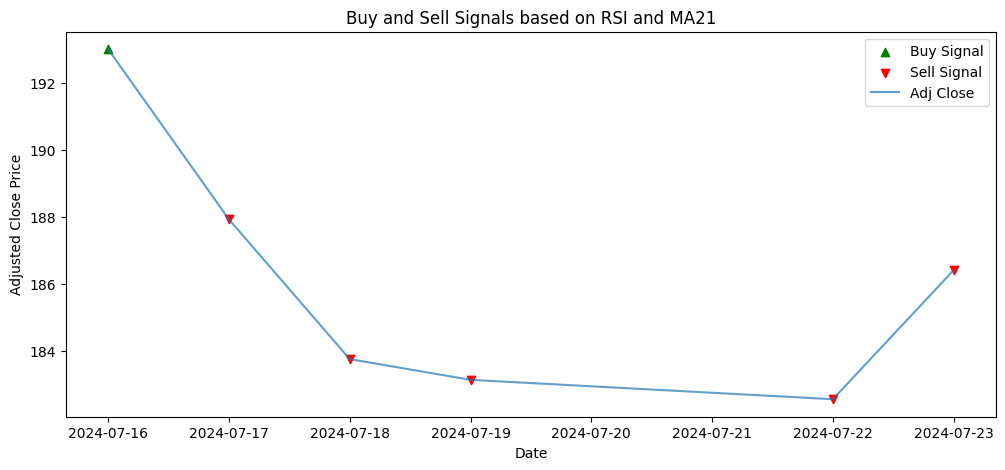

In [34]:
# Ensure d, Buy, and Sell DataFrames are available
d = RSI(tickers[3])
if not d.empty:
    Buy, Sell = getSignalRSI(d)
    
    # Extract indices for Buy and Sell signals
    buy_indices = Buy.index
    sell_indices = Sell.index

    # Plotting
    plt.figure(figsize=(12,5))
    plt.scatter(buy_indices, d.loc[buy_indices]['Adj Close'], marker='^', color='g', label='Buy Signal')
    plt.scatter(sell_indices, d.loc[sell_indices]['Adj Close'], marker='v', color='r', label='Sell Signal')
    plt.plot(d.index, d['Adj Close'], alpha=0.7, label='Adj Close')
    plt.legend()
    plt.title('Buy and Sell Signals based on RSI and MA21')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.show()
else:
    print("No data available for buy/sell signals.")


In [35]:
d = RSI(tickers[3])
if not d.empty:
    Buy, Sell = getSignalRSI(d)
    
    min_signals = min(len(Buy), len(Sell))
    buy_prices = Buy['Open'].values[:min_signals]
    sell_prices = Sell['Open'].values[:min_signals]
    
    profits = (sell_prices - buy_prices) / buy_prices

    # Calculate cumulative net profit
    Net_prof = (1 + profits).cumprod()
    print(Net_prof)
else:
    print("No data available for buy/sell signals.")


[*********************100%%**********************]  1 of 1 completed

[0.97832205]



/var/folders/28/x8q2f_yx2g7881jgwz63bk5r0000gn/T/ipykernel_33971/2606821930.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'YES' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Adj Close'] > df['MA21']) & (df['RSI'] < 30), 'BUY'] = "YES"


MACD Indicator

[*********************100%%**********************]  1 of 1 completed
/var/folders/28/x8q2f_yx2g7881jgwz63bk5r0000gn/T/ipykernel_33971/2606821930.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'YES' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Adj Close'] > df['MA21']) & (df['RSI'] < 30), 'BUY'] = "YES"


Profits: [-0.02167795]
Cumulative Net Profit: [0.97832205]


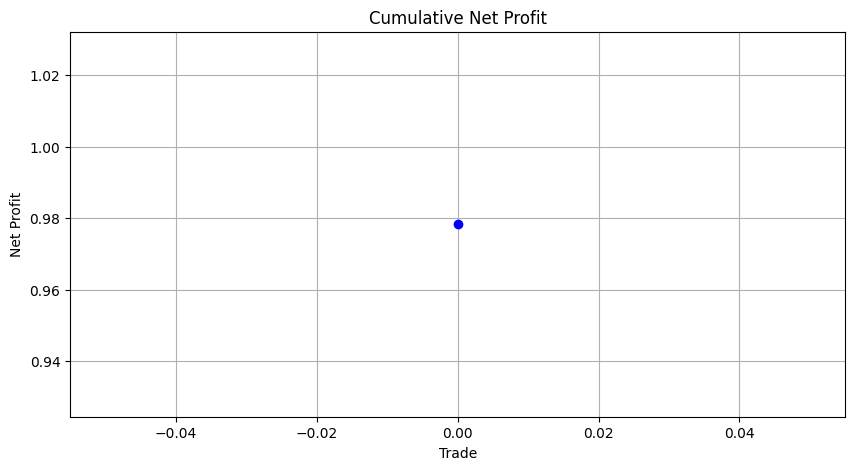

In [36]:
# Ensure d, Buy, and Sell DataFrames are available
d = RSI(tickers[3])
if not d.empty:
    Buy, Sell = getSignalRSI(d)
    
    # Ensure there are equal number of buy and sell signals for pairing
    min_signals = min(len(Buy), len(Sell))
    
    if min_signals > 0:
        buy_prices = Buy['Open'].values[:min_signals]
        sell_prices = Sell['Open'].values[:min_signals]
        
        # Calculate profits
        profits = (sell_prices - buy_prices) / buy_prices

        # Calculate cumulative net profit
        Net_prof = (1 + profits).cumprod()

        print("Profits:", profits)
        print("Cumulative Net Profit:", Net_prof)

        # Plot the cumulative net profit
        plt.figure(figsize=(10,5))
        plt.plot(Net_prof, marker='o', linestyle='-', color='b')
        plt.title('Cumulative Net Profit')
        plt.xlabel('Trade')
        plt.ylabel('Net Profit')
        plt.grid(True)
        plt.show()
    else:
        print("Not enough buy/sell signal pairs for profit calculation.")
else:
    print("No data available for buy/sell signals.")


[*********************100%%**********************]  1 of 1 completed


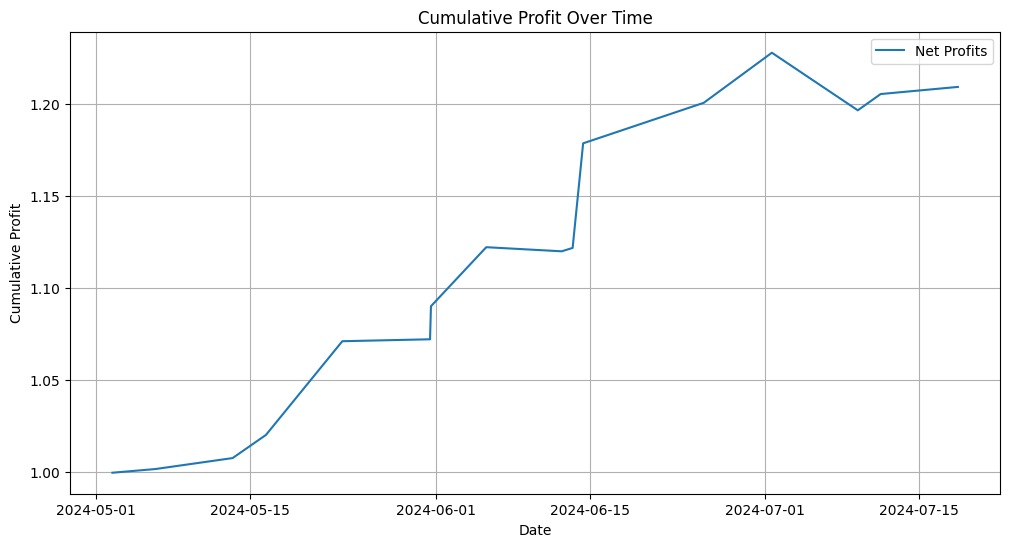

In [37]:
def MACD(asset):
    df = yf.download(asset, start='2024-05-01', end='2024-07-23', interval='1h')
    df['EMA12'] = df['Adj Close'].ewm(span=12).mean()
    df['EMA26'] = df['Adj Close'].ewm(span=26).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9).mean()
    return df

# Fetching data for HDFC Bank
MACD_Frame = MACD('HDFCBANK.BO')  # Use the appropriate ticker symbol

# Identifying Buy and Sell signals
Buy, Sell = [], []
for i in range(1, len(MACD_Frame)):
    if MACD_Frame.MACD.iloc[i] > MACD_Frame.Signal.iloc[i] and MACD_Frame.MACD.iloc[i - 1] < MACD_Frame.Signal.iloc[i - 1]:
        Buy.append(i)
    elif MACD_Frame.MACD.iloc[i] < MACD_Frame.Signal.iloc[i] and MACD_Frame.MACD.iloc[i - 1] > MACD_Frame.Signal.iloc[i - 1]:
        Sell.append(i)

# Ensure that Buy and Sell signals are within bounds
Buy = [i for i in Buy if i < len(MACD_Frame)]
Sell = [i for i in Sell if i < len(MACD_Frame)]

# Match Buy and Sell signals
Buy_Price = MACD_Frame['Open'].iloc[Buy]
Sell_Price = MACD_Frame['Open'].iloc[Sell]

# Adjust Buy/Sell lists to match in length
if Buy_Price.index[0] > Sell_Price.index[0]:
    Sell_Price = Sell_Price.drop(Sell_Price.index[-1])
elif Buy_Price.index[-1] > Sell_Price.index[-1]:
    Buy_Price = Buy_Price.drop(Buy_Price.index[-1])

# Calculate Profits
Profits = []
for i in range(len(Buy_Price)):
    Profits.append((Sell_Price.iloc[i] - Buy_Price.iloc[i]) / Buy_Price.iloc[i])

Profits = np.array(Profits)
Net_Profits = (1 + Profits).cumprod()

# Ensure dates align with profits
dates = MACD_Frame.index[Buy[:len(Net_Profits)]]

# Plot cumulative profit over time
plt.figure(figsize=(12, 6))
plt.plot(dates, Net_Profits, label='Net Profits')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit Over Time')
plt.legend()
plt.grid(True)
plt.show()
